In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

# Set style for all plots
sns.set_theme(style="whitegrid")

# Suppress warnings for cleaner notebook output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Define the file path
RAW_DATA_FILE = 'used_cars_kaggle.csv'
print(f"Loading raw data from: {RAW_DATA_FILE}")

# Load the dataset
df = pd.read_csv(RAW_DATA_FILE)
df.columns = df.columns.str.strip()
df.head()
# %%


Loading raw data from: used_cars_kaggle.csv


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [2]:
# %%
# 1. Clean 'price' and 'milage' columns
print("Cleaning 'price' and 'milage' columns...")
df['price'] = df['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
df['milage'] = df['milage'].astype(str).str.replace(' mi.', '', regex=False).str.replace(',', '', regex=False).astype(float)

# 2. Handle Inconsistent/Missing Categorical Values
print("Handling missing/inconsistent categorical values...")

# Clean fuel_type inconsistent values
df['fuel_type'] = df['fuel_type'].replace(['–', 'not supported'], np.nan)

# Impute NaNs with the Mode for key categorical columns
impute_cols = ['fuel_type', 'accident', 'clean_title']

for col in impute_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

print("\nMissing Values Check (All should be 0):")
print(df[impute_cols].isnull().sum())
df.head()
# %%

Cleaning 'price' and 'milage' columns...
Handling missing/inconsistent categorical values...

Missing Values Check (All should be 0):
fuel_type      0
accident       0
clean_title    0
dtype: int64


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.0
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.0
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,Yes,54598.0
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500.0
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,Yes,34999.0


Log Transformation complete. New target column 'log_price' created.


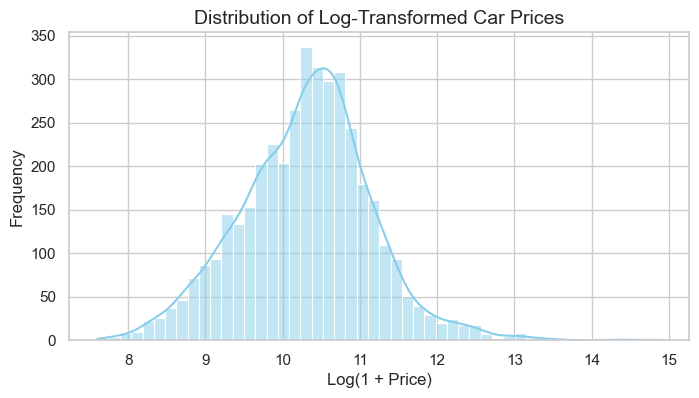

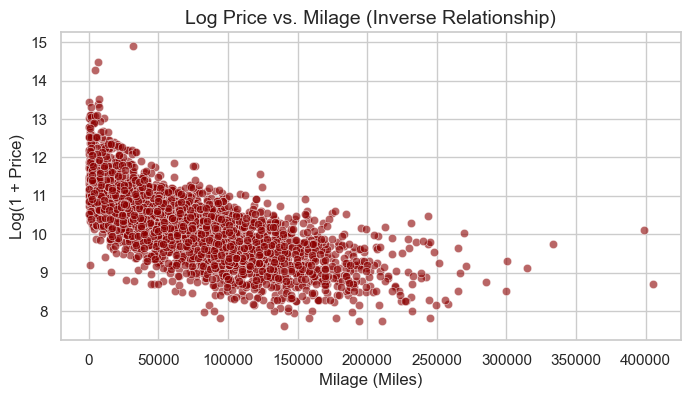

In [3]:
# %%
# 1. Log Transformation
df['log_price'] = np.log1p(df['price'])
print("Log Transformation complete. New target column 'log_price' created.")

# 2. Visualize Log-Price Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['log_price'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Log-Transformed Car Prices', fontsize=14)
plt.xlabel('Log(1 + Price)')
plt.ylabel('Frequency')
plt.show()

# 3. Visualize Price vs. Milage (Log Scale)
plt.figure(figsize=(8, 4))
sns.scatterplot(x='milage', y='log_price', data=df, alpha=0.6, color='darkred')
plt.title('Log Price vs. Milage (Inverse Relationship)', fontsize=14)
plt.xlabel('Milage (Miles)')
plt.ylabel('Log(1 + Price)')
plt.show()
# %%

In [4]:
# %%
# 1. Feature Selection
selected_features = ['model_year', 'milage', 'brand', 'fuel_type', 'transmission', 'accident', 'clean_title']
df_features = df[selected_features]
categorical_cols = df_features.select_dtypes(include='object').columns

# 2. One-Hot Encoding
df_encoded = pd.get_dummies(df_features, columns=categorical_cols, drop_first=True)
df_encoded['log_price'] = df['log_price']

# 3. Define X and y
X = df_encoded.drop(columns=['log_price'])
y = df_encoded['log_price']

# 4. Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Split Complete.")
print(f"Training features shape: {X_train.shape}")
print(f"Total features after encoding: {X.shape[1]}")
# %%

Data Split Complete.
Training features shape: (3207, 124)
Total features after encoding: 124


In [5]:
# %%
# 1. Train the Random Forest Regressor
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=5)
rf_model.fit(X_train, y_train)

# 2. Evaluate
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_approx_error_usd = np.expm1(rf_rmse)

print("\n--- Model Evaluation ---")
print(f"Random Forest RMSE (Log Scale): {rf_rmse:.4f}")
print(f"Random Forest Approx. Error (USD): ${rf_approx_error_usd:,.2f}")
# %%

Training Random Forest Regressor...

--- Model Evaluation ---
Random Forest RMSE (Log Scale): 0.4752
Random Forest Approx. Error (USD): $0.61


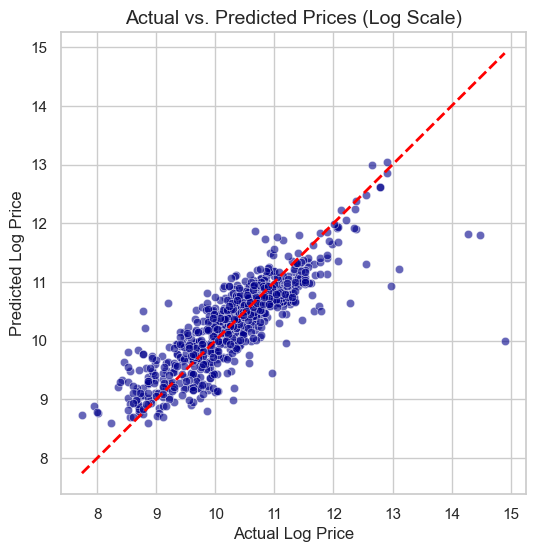

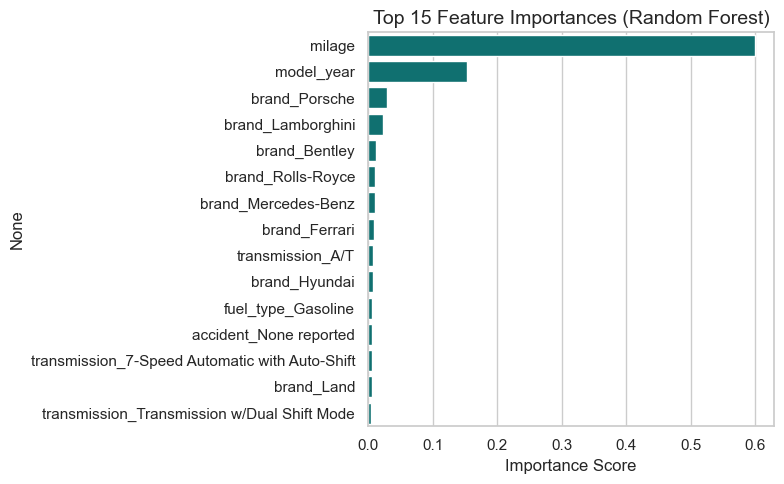

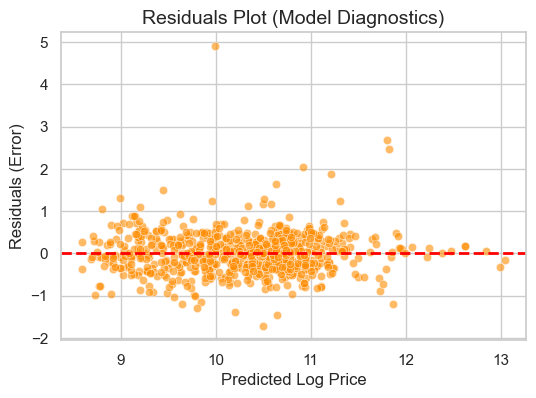

In [6]:
# %%
# 1. Actual vs. Predicted Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.6, color='darkblue')
# Add the ideal 45-degree line
max_val = max(y_test.max(), rf_predictions.max())
min_val = min(y_test.min(), rf_predictions.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Prices (Log Scale)', fontsize=14)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.show()

# 2. Feature Importance Bar Chart (Top 15)
plt.figure(figsize=(8, 5))
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_15_features = feature_importances.nlargest(15)
sns.barplot(x=top_15_features.values, y=top_15_features.index, color='teal')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 3. Residuals Plot
plt.figure(figsize=(6, 4))
residuals = y_test - rf_predictions
sns.scatterplot(x=rf_predictions, y=residuals, alpha=0.6, color='darkorange')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals Plot (Model Diagnostics)', fontsize=14)
plt.xlabel('Predicted Log Price')
plt.ylabel('Residuals (Error)')
plt.show()
# %%

In [7]:
# %%
# 1. Retrain model on full dataset for final deployment prediction
final_rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=5)
final_rf_model.fit(X, y)

# 2. Define Hypothetical New Car Data
hypothetical_cars = [
    {'model_year': 2024, 'milage': 5000.0, 'brand': 'Land Rover', 'fuel_type': 'Hybrid', 'transmission': '8-Speed Automatic', 'accident': 'None reported', 'clean_title': 'Yes'},
    {'model_year': 2018, 'milage': 75000.0, 'brand': 'Honda', 'fuel_type': 'Gasoline', 'transmission': 'Automatic', 'accident': 'None reported', 'clean_title': 'Yes'},
    {'model_year': 2010, 'milage': 150000.0, 'brand': 'Ford', 'fuel_type': 'Gasoline', 'transmission': '6-Speed A/T', 'accident': 'At least 1 accident or damage reported', 'clean_title': 'Yes'}
]
df_new = pd.DataFrame(hypothetical_cars)

# 3. Encode and Align New Data
categorical_cols = X.select_dtypes(include='object').columns
df_new_encoded = pd.get_dummies(df_new, columns=categorical_cols, drop_first=True)

# Align columns (critical step!)
missing_cols = set(X.columns) - set(df_new_encoded.columns)
for c in missing_cols:
    df_new_encoded[c] = 0
df_new_encoded = df_new_encoded[X.columns]

# 4. Predict and Convert back to USD
log_predictions = final_rf_model.predict(df_new_encoded)
predicted_prices = np.expm1(log_predictions)

results = df_new.copy()
results['Predicted_Price_USD'] = predicted_prices.round(2)
results['Predicted_Price_USD'] = results['Predicted_Price_USD'].apply(lambda x: f"${x:,.2f}")

print("\n--- Final Predicted Prices ---")
print(results)
# %%


--- Final Predicted Prices ---
   model_year    milage       brand fuel_type       transmission  \
0        2024    5000.0  Land Rover    Hybrid  8-Speed Automatic   
1        2018   75000.0       Honda  Gasoline          Automatic   
2        2010  150000.0        Ford  Gasoline        6-Speed A/T   

                                 accident clean_title Predicted_Price_USD  
0                           None reported         Yes          $61,394.93  
1                           None reported         Yes          $44,152.99  
2  At least 1 accident or damage reported         Yes          $15,917.07  


C:\Users\aniru\AppData\Local\Temp\ipykernel_16432\3775233520.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new_encoded[c] = 0
C:\Users\aniru\AppData\Local\Temp\ipykernel_16432\3775233520.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new_encoded[c] = 0
C:\Users\aniru\AppData\Local\Temp\ipykernel_16432\3775233520.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c